In [1]:
#for data processing
import pandas as pd
import numpy as np
import string
import re

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#for nlp
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from keras.preprocessing import sequence
from tensorflow.python.keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM
from sklearn import preprocessing
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
np.random.seed(0)
from keras.optimizers import RMSprop
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import os
import math

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\ProgramData\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#load train data
cols = ['id', 'text', 'label', 'intensity']

anger_train = pd.read_csv("C:/projects/Train/anger-ratings-0to1.train.txt", header=None, sep='\t', names=cols, index_col=0)
fear_train = pd.read_csv("C:/projects/Train/fear-ratings-0to1.train.txt", header=None, sep='\t', names=cols, index_col=0)
sad_train = pd.read_csv("C:/projects/Train/joy-ratings-0to1.train.txt", header=None, sep='\t', names=cols, index_col=0)
joy_train = pd.read_csv("C:/projects/Train/sadness-ratings-0to1.train.txt", header=None, sep='\t', names=cols, index_col=0)

In [3]:
anger_train.head(2)

,text,label,intensity
id,,,
10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
10001,So my Indian Uber driver just called someone t...,anger,0.896


In [4]:
fear_train.head(2)

,text,label,intensity
id,,,
20000,I feel like I am drowning. #depression #anxiet...,fear,0.979
20001,I get so nervous even thinking about talking t...,fear,0.979


In [5]:
sad_train.head(2)

,text,label,intensity
id,,,
30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980
30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958


In [6]:
joy_train.head(2)

,text,label,intensity
id,,,
40000,Depression sucks! #depression,sadness,0.958
40001,Feeling worthless as always #depression,sadness,0.958


In [7]:
train_df = pd.concat([anger_train, fear_train, sad_train, joy_train])

In [8]:
train_df.head()

,text,label,intensity
id,,,
10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
10001,So my Indian Uber driver just called someone t...,anger,0.896
10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3613 entries, 10000 to 40785
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       3613 non-null   object 
 1   label      3613 non-null   object 
 2   intensity  3613 non-null   float64
dtypes: float64(1), object(2)
memory usage: 112.9+ KB


In [10]:
train_df.reset_index(inplace=True)
train_df.label.value_counts()

label
fear       1147
anger       857
joy         823
sadness     786
Name: count, dtype: int64

In [11]:
punctuated = string.punctuation
train_df['word_count'] = train_df['text'].apply(lambda x:len(x.split()))
train_df['char_count'] = train_df['text'].apply(lambda x:len(x.replace(' ','')))
train_df['punc_count'] = train_df['text'].apply(lambda x:len([a for a in x if a in punctuated]))
train_df.head()

,id,text,label,intensity,word_count,char_count,punc_count
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,18,79,12
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,23,97,4
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,19,90,4
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,24,111,13
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,24,102,6


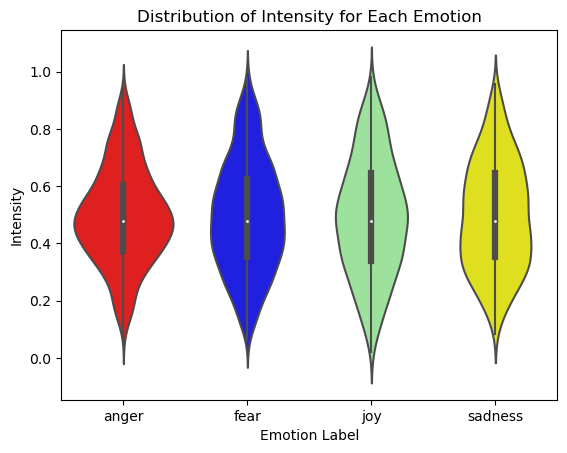

In [12]:
colors = {'label1': 'red', 'label2': 'blue', 'label3': 'lightgreen', 'label4': 'yellow'}
sns.violinplot(data=train_df, x='label', y='intensity', palette=colors.values())
plt.xlabel('Emotion Label')
plt.ylabel('Intensity')
plt.title('Distribution of Intensity for Each Emotion')
plt.show()

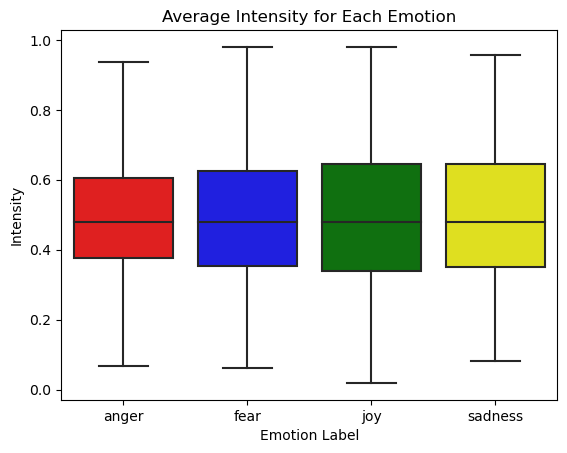

In [13]:
colors = {'label1': 'red', 'label2': 'blue', 'label3': 'green', 'label4': 'yellow'}
bplot = sns.boxplot(data=train_df, x='label', y='intensity', palette=colors.values())
for i, artist in enumerate(bplot.artists):
    artist.set_edgecolor('black')
    artist.set_facecolor(colors[data_training['label'].unique()[i]])
plt.xlabel('Emotion Label')
plt.ylabel('Intensity')
plt.title('Average Intensity for Each Emotion')
plt.show()


In [14]:
#Join the text in each emotion
text_fear = ' '.join(train_df[train_df['label']=='fear']['text'].values)
text_anger = ' '.join(train_df[train_df['label']=='anger']['text'].values)
text_joy = ' '.join(train_df[train_df['label']=='joy']['text'].values)
text_sadness = ' '.join(train_df[train_df['label']=='sadness']['text'].values)

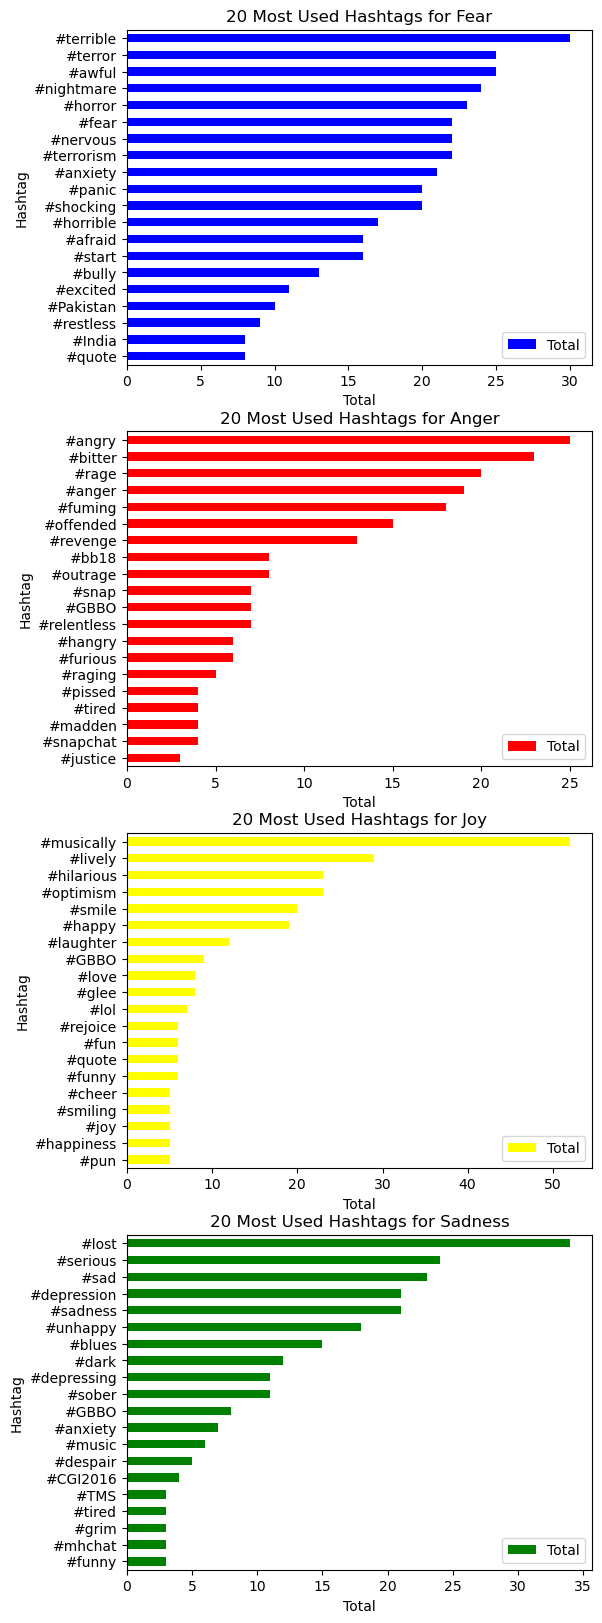

In [15]:
def plot_hashtags(ax, emotion_text, color, emotion_name):
    hashtag_counter = Counter(word for word in emotion_text.split(' ') if word != '' and word[0] == '#')
    most_common = hashtag_counter.most_common(20)
    df = pd.DataFrame(most_common, columns=["Hashtag", "Total"])
    df.plot.barh(y="Total", x="Hashtag", ax=ax, color=color, title=f"20 Most Used Hashtags for {emotion_name}")
    ax.set_xlabel("Total")
    ax.set_ylabel("Hashtag")
    ax.invert_yaxis()  # Invert y-axis for better readability

# Assuming you have text_fear, text_anger, text_joy, text_sadness variables

# Create subplots with proper spacing
fig, axes = plt.subplots(4, 1, figsize=(6, 20))
fig.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots

# Plot hashtags for each emotion
plot_hashtags(axes[0], text_fear, "blue", "Fear")
plot_hashtags(axes[1], text_anger, "red", "Anger")
plot_hashtags(axes[2], text_joy, "yellow", "Joy")
plot_hashtags(axes[3], text_sadness, "green", "Sadness")

plt.show()


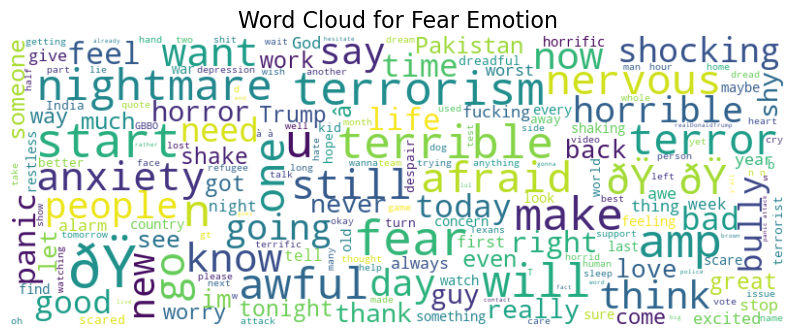

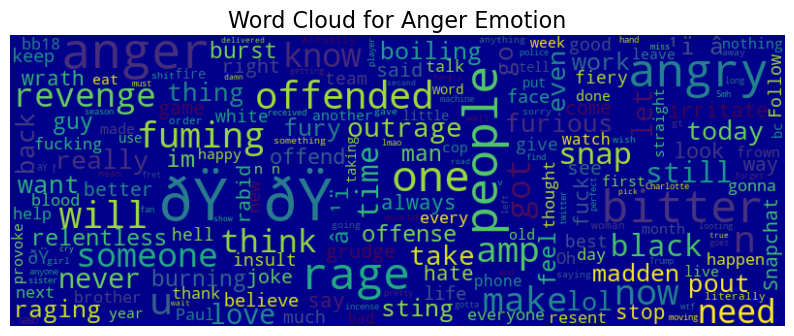

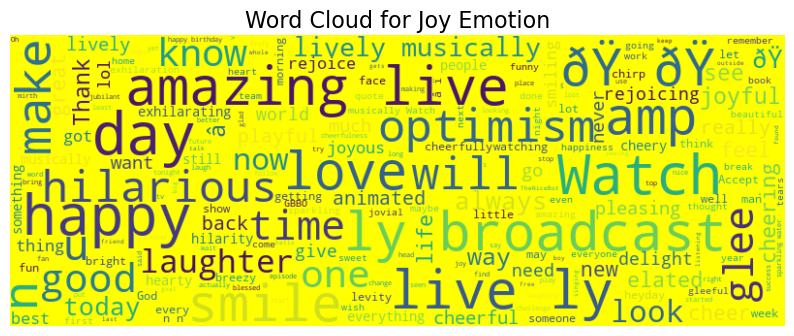

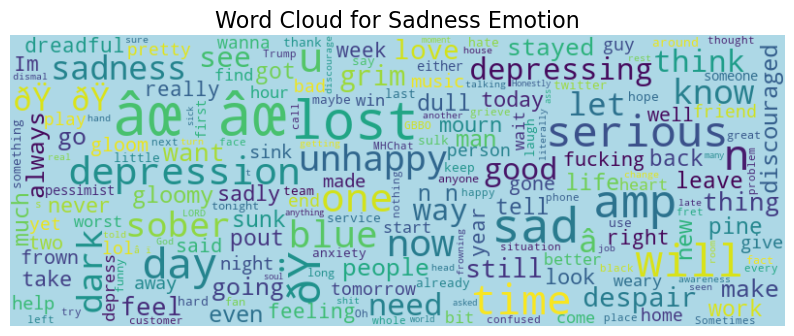

In [16]:
def generate_wordcloud(text, background_color, emotion_name):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(max_font_size=60, background_color=background_color, stopwords=stopwords, width=800, height=300).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {emotion_name} Emotion', fontsize=16)
    plt.show()

# Assuming join_text_fear, join_text_anger, join_text_joy, and join_text_sadness are defined
generate_wordcloud(text_fear, 'white', 'Fear')
generate_wordcloud(text_anger, 'darkblue', 'Anger')
generate_wordcloud(text_joy, 'yellow', 'Joy')
generate_wordcloud(text_sadness, 'lightblue', 'Sadness')

In [17]:
import re

class TextCleaner:

    def __init__(self, text: str):
        self.text = text

    def fully_clean(self):
        return self \
            .remove_urls() \
            .remove_mentions() \
            .remove_hashtags() \
            .remove_reserved_words() \
            .remove_punctuation() \
            .remove_single_letter_words() \
            .remove_blank_spaces() \
            .remove_stopwords() \
            .remove_numbers() \
            .remove_non_ascii() \
            .lowercase()

    def remove_urls(self):
        url_pattern = re.compile(
            r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
            r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')
        self.text = re.sub(pattern=url_pattern, repl='', string=self.text)
        return self

    def remove_punctuation(self):
        self.text = self.text.translate(str.maketrans('', '', string.punctuation))
        return self

    def remove_mentions(self):
        mentions_pattern = re.compile(r'@\w*')
        self.text = re.sub(pattern=mentions_pattern, repl='', string=self.text)
        return self

    def remove_hashtags(self):
        hashtags_pattern = re.compile(r'#\w*')
        self.text = re.sub(pattern=hashtags_pattern, repl='', string=self.text)
        return self

    def remove_reserved_words(self):
        reserved_words_pattern = re.compile(r'(RT|rt|FAV|fav|VIA|via)')
        self.text = re.sub(pattern=reserved_words_pattern, repl='', string=self.text)
        return self

    def remove_single_letter_words(self):
        single_letter_words_pattern = re.compile(r'(?<![\w\-])\w(?![\w\-])')
        self.text = re.sub(pattern=single_letter_words_pattern, repl='', string=self.text)
        return self

    def remove_blank_spaces(self):
        blank_spaces_pattern = re.compile(r'\s{2,}|\t')
        self.text = re.sub(pattern=blank_spaces_pattern, repl=' ', string=self.text)
        return self

    def remove_stopwords(self, extra_stopwords=None):
        if extra_stopwords is None:
            extra_stopwords = []
        tokenizer = TweetTokenizer()
        words = tokenizer.tokenize(self.text)
        stop_words = set(stopwords.words('english'))

        new_sentence = [w for w in words if w.lower() not in stop_words and w.lower() not in extra_stopwords]
        self.text = ' '.join(new_sentence)
        return self

    def remove_numbers(self, preserve_years=False):
        text_list = self.text.split(' ')
        for text in text_list[:]:
            if text.isnumeric():
                if preserve_years:
                    if not is_year(text):
                        text_list.remove(text)
                else:
                    text_list.remove(text)

        self.text = ' '.join(text_list)
        return self
    
    def is_year(self, text):
        try:
            year = int(text)
            return 1000 <= year <= 9999
        except ValueError:
            return False
    
    def remove_non_ascii(self):
        self.text = ''.join(char for char in self.text if ord(char) < 128)
        return self

    def lowercase(self):
        self.text = self.text.lower()
        return self



In [18]:
train_df.head(3)

,id,text,label,intensity,word_count,char_count,punc_count
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,18,79,12
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,23,97,4
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,19,90,4


In [20]:
# Import TweetTokenizer
from nltk.tokenize import TweetTokenizer

# Rest of your code
text = train_df['text']
clean_text = []

for text_entry in text:
    c = TextCleaner(text_entry)
    c.fully_clean()
    cleaned_text = c.text
    clean_text.append(cleaned_text)

train_df['clean_text'] = clean_text 
train_df.head(5)

,id,text,label,intensity,word_count,char_count,punc_count,clean_text
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,18,79,12,fuk heck moved fridge knock landlord door
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,23,97,4,indian uber driver called someone word wasnt m...
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,19,90,4,asked parcel delivered pick store address
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,24,111,13,ef whichever butt wipe pulled fire alarm davis...
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,24,102,6,dont join put phone talk rude taking money acc...


In [21]:
#Join the text in each emotion
cleantext_fear = ' '.join(train_df[train_df['label']=='fear']['clean_text'].values)
cleantext_anger = ' '.join(train_df[train_df['label']=='anger']['clean_text'].values)
cleantext_joy = ' '.join(train_df[train_df['label']=='joy']['clean_text'].values)
cleantext_sadness = ' '.join(train_df[train_df['label']=='sadness']['clean_text'].values)

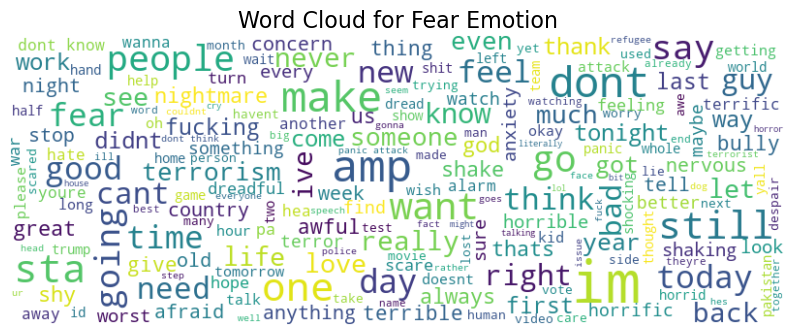

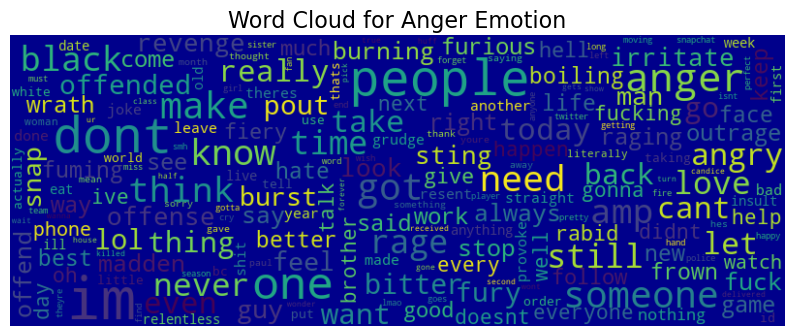

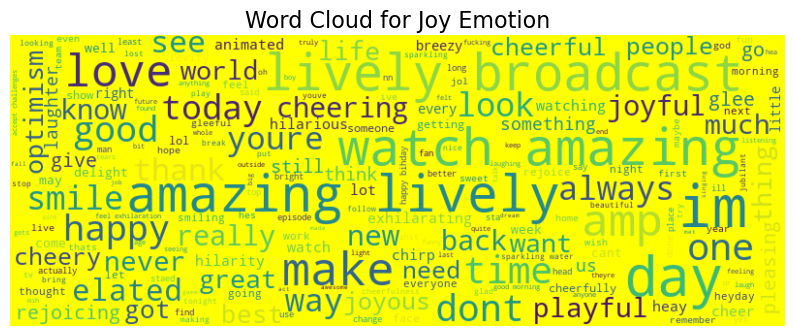

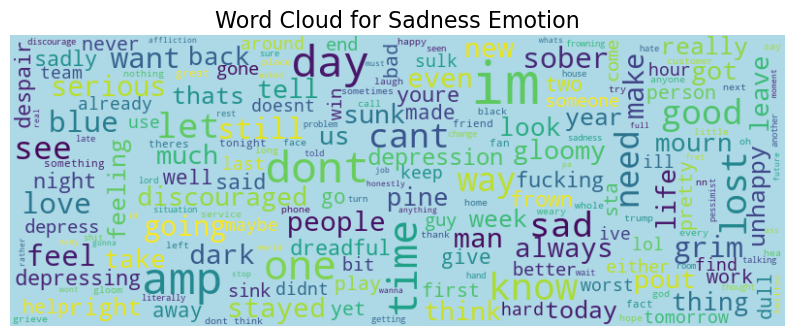

In [22]:
def generate_wordcloud(text, background_color, emotion_name):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(max_font_size=60, background_color=background_color, stopwords=stopwords, width=800, height=300).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {emotion_name} Emotion', fontsize=16)
    plt.show()

# Assuming join_text_fear, join_text_anger, join_text_joy, and join_text_sadness are defined
generate_wordcloud(cleantext_fear, 'white', 'Fear')
generate_wordcloud(cleantext_anger, 'darkblue', 'Anger')
generate_wordcloud(cleantext_joy, 'yellow', 'Joy')
generate_wordcloud(cleantext_sadness, 'lightblue', 'Sadness')

In [23]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\akank\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

(array([ 43., 140., 144., 147., 208., 211., 172., 153., 118., 787.,  74.,
         96., 106., 215., 183., 164., 227., 195., 163.,  67.]),
 array([-0.9686 , -0.87161, -0.77462, -0.67763, -0.58064, -0.48365,
        -0.38666, -0.28967, -0.19268, -0.09569,  0.0013 ,  0.09829,
         0.19528,  0.29227,  0.38926,  0.48625,  0.58324,  0.68023,
         0.77722,  0.87421,  0.9712 ]),
 <BarContainer object of 20 artists>)

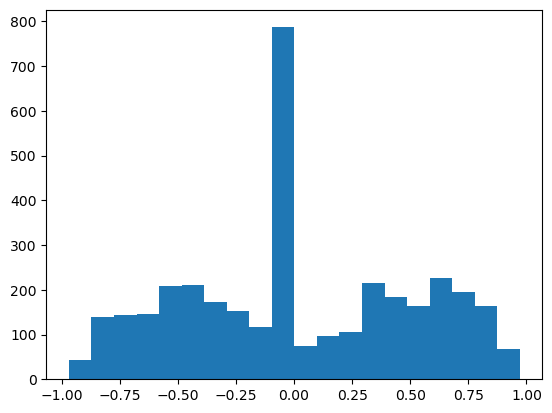

In [25]:
# creating analyzer object 
analyzer = SentimentIntensityAnalyzer()

# get a list of scores and plot
scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in train_df['clean_text']]
plt.hist(scores, bins=20)

In [26]:
sentiment = train_df['clean_text'].apply(lambda x: analyzer.polarity_scores(x))
clean_traindf = pd.concat([train_df,sentiment.apply(pd.Series)],axis = 1)
clean_traindf.head(5)

,id,text,label,intensity,word_count,char_count,punc_count,clean_text,neg,neu,pos,compound
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,18,79,12,fuk heck moved fridge knock landlord door,0.000,1.000,0.0,0.0000
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,23,97,4,indian uber driver called someone word wasnt m...,0.000,1.000,0.0,0.0000
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,19,90,4,asked parcel delivered pick store address,0.000,1.000,0.0,0.0000
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,24,111,13,ef whichever butt wipe pulled fire alarm davis...,0.348,0.652,0.0,-0.5859
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,24,102,6,dont join put phone talk rude taking money acc...,0.379,0.621,0.0,-0.5978


In [27]:
clean_traindf.describe()

,id,intensity,word_count,char_count,punc_count,neg,neu,pos,compound
count,3613.000000,3613.000000,3613.000000,3613.000000,3613.000000,3613.000000,3613.000000,3613.000000,3613.000000
mean,24719.287296,0.495199,16.033213,80.681982,4.647384,0.193953,0.594415,0.210524,0.026397
std,10715.806835,0.190368,6.650965,31.320980,3.387929,0.229183,0.261687,0.238415,0.490928
min,10000.000000,0.019000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,-0.968600
25%,20046.000000,0.354000,10.000000,55.000000,2.000000,0.000000,0.408000,0.000000,-0.381800
50%,20949.000000,0.479000,17.000000,84.000000,4.000000,0.126000,0.570000,0.159000,0.000000
75%,30705.000000,0.625000,22.000000,110.000000,6.000000,0.350000,0.770000,0.376000,0.440400
max,40785.000000,0.980000,32.000000,275.000000,29.000000,1.000000,1.000000,1.000000,0.971200


Intensity: A mean intensity of approximately 0.495 suggests that the sentiments in the dataset are moderately intense.

Word Count and Character Count: The average word count is around 16, and the average character count is approximately 80.68. This information provides insight into the length of the text entries.

Punctuation Count: With an average punctuation count of about 4.65, you can observe how punctuation is distributed in the text entries. It might be interesting to see if there's any correlation between punctuation and sentiment.

Sentiment Proportions (neg, neu, pos): The mean values for neg (0.193953), neu (0.594415), and pos (0.210524) suggest that, on average, the dataset contains more neutral sentiment followed by positive and then negative sentiment.

Compound Score: The mean compound score is very close to zero (0.026397), indicating a roughly balanced mix of positive and negative sentiment in the dataset.

## SUMMARY - 
the dataset comprises text entries with moderately intense sentiments, as indicated by a mean intensity of approximately 0.495. The average word count and character count are 16 and 80.68, respectively, showcasing moderate text length with notable variability. Punctuation use, averaging 4.65, offers insights into sentence complexity. Sentiment analysis reveals a balanced mix, with higher proportions of neutral (0.594415) and positive (0.210524) sentiments. The compound score, close to zero (0.026397), signifies a nuanced interplay of positive and negative sentiments.

In [28]:
from nltk.probability import FreqDist

In [29]:
import string

# Sample data (replace this with your actual data)
sad_text = train_df[train_df['label']=='sadness']['text'].values
joyful_text = train_df[train_df['label']=='joy']['text'].values

# Tokenize and preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    # Modify this line to handle specific cases (e.g., keeping words with hashes)
    tokens = [token for token in word_tokenize(text) if token.isalpha() and token not in stop_words]
    return tokens

sad_tokens = [token for text in sad_text for token in preprocess_text(text)]
joyful_tokens = [token for text in joyful_text for token in preprocess_text(text)]

# Create frequency distributions
sad_freq_dist = FreqDist(sad_tokens)
joyful_freq_dist = FreqDist(joyful_tokens)

# Identify common words
common_words = set(sad_freq_dist.keys()) & set(joyful_freq_dist.keys())

# Print common words (replace print statements with your logic to filter out these words)
# print("Common Words:", common_words)- Unhash it see the unique 975 words or refer to the below cell code

print("Number of tokens in sadness text:", len(sad_tokens), end=' \n')
print("Number of tokens in joyful text:", len(joyful_tokens), end='\n')
print("Frequency distribution size for sadness text:", len(sad_freq_dist), end='\n')
print("Frequency distribution size for joyful text:", len(joyful_freq_dist), end='\n\n')

unique_common_word_count = len(common_words)  # Calculate unique_common_word_count here

total_unique_words = len(set(sad_tokens) | set(joyful_tokens))
common_word_percentage = (len(common_words) / total_unique_words) * 100

# Print the result
print(f'Unique count of common words: {unique_common_word_count}', end='\n')
print(f'Total unique words: {total_unique_words}', end='\n\n')
print(f'Common Word Percentage: {common_word_percentage:.2f}%')

Number of tokens in sadness text: 7029 
Number of tokens in joyful text: 7044
Frequency distribution size for sadness text: 3172
Frequency distribution size for joyful text: 2942

Unique count of common words: 975
Total unique words: 5139

Common Word Percentage: 18.97%


In [30]:
common_word_counts = {word: (sad_freq_dist[word], joyful_freq_dist[word]) for word in common_words}

# Print the count of occurrences for each common word
for word, counts in common_word_counts.items():
    print(f'Word: {word}, Sad Count: {counts[0]}, Joyful Count: {counts[1]}')
    
# unique_common_word_count = len(set(common_words))
# print(f'Unique count of common words: {unique_common_word_count}')

Word: marks, Sad Count: 2, Joyful Count: 1
Word: play, Sad Count: 10, Joyful Count: 5
Word: worse, Sad Count: 1, Joyful Count: 3
Word: adult, Sad Count: 2, Joyful Count: 1
Word: choose, Sad Count: 1, Joyful Count: 2
Word: also, Sad Count: 7, Joyful Count: 7
Word: water, Sad Count: 1, Joyful Count: 9
Word: online, Sad Count: 3, Joyful Count: 3
Word: hey, Sad Count: 1, Joyful Count: 5
Word: take, Sad Count: 12, Joyful Count: 3
Word: services, Sad Count: 3, Joyful Count: 1
Word: places, Sad Count: 2, Joyful Count: 1
Word: bottle, Sad Count: 2, Joyful Count: 1
Word: work, Sad Count: 15, Joyful Count: 10
Word: walked, Sad Count: 1, Joyful Count: 1
Word: waiting, Sad Count: 4, Joyful Count: 2
Word: question, Sad Count: 2, Joyful Count: 1
Word: later, Sad Count: 3, Joyful Count: 1
Word: nice, Sad Count: 4, Joyful Count: 7
Word: incredibly, Sad Count: 2, Joyful Count: 1
Word: date, Sad Count: 2, Joyful Count: 2
Word: never, Sad Count: 15, Joyful Count: 17
Word: defending, Sad Count: 2, Joyful 